<a href="https://colab.research.google.com/github/MantisOrquida/Clase-aprendizaje-profundo/blob/main/Tarea%202/Fran_Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random

In [2]:
# Usaremos la base de datos: Beijing Multi-Site Air-Quality Data Data Set,
# la cual puede ser obtenida desde https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
# (revisar la página para más detalles sobre los datos)
# Se ha proporcionado un archivo csv con la información obtenida de la estación
# de monitoreo Aotizhongxin, el cual contiene 35,064 registros.

# El objetivo es poder predecir la concetración de PM2.5 y de PM10 a partir de las
# variables año, mes, día, hora, temperatura, presión, punto de rocío, 
# precipitación y velocidad del viento.

In [3]:
# Requiered to select a file to be imported
from google.colab import files
uploaded = files.upload()

Saving PRSA_Aotizhongxin.csv to PRSA_Aotizhongxin.csv


# Part 1: Load data into Colab

In [4]:
# Import file and store it in a data frame
import io
df = pd.read_csv(io.BytesIO(uploaded['PRSA_Aotizhongxin.csv'])) # Cambia al nombre del archivo que cargues
df.dropna(inplace=True)
df
# Quedan 31,815 registros despues de eliminar NaN's

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


In [5]:
W = pd.get_dummies(df['wd'], prefix='wd')
print(W.head())
W['PM2.5'] = df['PM2.5']
W['PM10'] = df['PM10']
W['SO2'] = df['PM2.5']
W['NO2'] = df['PM2.5']
W['CO'] = df['PM2.5']
W['O3'] = df['PM2.5']
print(W.corr(method= 'pearson'))

   wd_E  wd_ENE  wd_ESE  wd_N  wd_NE  ...  wd_SSW  wd_SW  wd_W  wd_WNW  wd_WSW
0     0       0       0     0      0  ...       0      0     0       0       0
1     0       0       0     1      0  ...       0      0     0       0       0
2     0       0       0     0      0  ...       0      0     0       0       0
3     0       0       0     0      0  ...       0      0     0       0       0
4     0       0       0     1      0  ...       0      0     0       0       0

[5 rows x 16 columns]
            wd_E    wd_ENE    wd_ESE  ...       NO2        CO        O3
wd_E    1.000000 -0.101553 -0.065770  ...  0.088728  0.088728  0.088728
wd_ENE -0.101553  1.000000 -0.082194  ...  0.099292  0.099292  0.099292
wd_ESE -0.065770 -0.082194  1.000000  ...  0.062765  0.062765  0.062765
wd_N   -0.071175 -0.088949 -0.057607  ... -0.085490 -0.085490 -0.085490
wd_NE  -0.116913 -0.146109 -0.094627  ...  0.056573  0.056573  0.056573
wd_NNE -0.078206 -0.097736 -0.063298  ... -0.051872 -0.051872 -0.051872

In [6]:
def histogram_intersection(a, b):

    v = np.minimum(a, b).sum().round(decimals=1)

    return v

print(df[['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].corr(method= 'pearson'))
print(df[['PM10', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].corr(method= 'pearson'))
print(df[['SO2', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].corr(method= 'pearson'))
print(df[['NO2', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].corr(method= 'pearson'))
print(df[['CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].corr(method= 'pearson'))
print(df[['O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].corr(method= 'pearson'))


          PM2.5      TEMP      PRES      DEWP      RAIN      WSPM
PM2.5  1.000000 -0.125711 -0.008697  0.125706 -0.020498 -0.286331
TEMP  -0.125711  1.000000 -0.828165  0.821037  0.037579  0.031122
PRES  -0.008697 -0.828165  1.000000 -0.774608 -0.064901  0.076706
DEWP   0.125706  0.821037 -0.774608  1.000000  0.086918 -0.311576
RAIN  -0.020498  0.037579 -0.064901  0.086918  1.000000  0.021354
WSPM  -0.286331  0.031122  0.076706 -0.311576  0.021354  1.000000
          PM10      TEMP      PRES      DEWP      RAIN      WSPM
PM10  1.000000 -0.110371 -0.034957  0.063988 -0.032775 -0.188684
TEMP -0.110371  1.000000 -0.828165  0.821037  0.037579  0.031122
PRES -0.034957 -0.828165  1.000000 -0.774608 -0.064901  0.076706
DEWP  0.063988  0.821037 -0.774608  1.000000  0.086918 -0.311576
RAIN -0.032775  0.037579 -0.064901  0.086918  1.000000  0.021354
WSPM -0.188684  0.031122  0.076706 -0.311576  0.021354  1.000000
           SO2      TEMP      PRES      DEWP      RAIN      WSPM
SO2   1.000000 -0.

# Part 2: Format data and split it into numpy arrays

In [7]:
# AUX function to put categorical data into one-hot encoding format
from sklearn.preprocessing import OneHotEncoder
def winddir_to_categorical(winddir):
  enc = OneHotEncoder(sparse=False)
  WD = enc.fit_transform(winddir)
  print("== categories:", enc.categories_, "==")
  return WD

== categories: [array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object)] ==
Input values X with shape (31815, 19). With values
 min = [-16.8 985.9   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]
 mean = [1.37756108e+01 1.01180038e+03 1.72047148e+00 7.51532296e-02
 1.12619833e-01 5.05421971e-02 5.86830112e-02 1.43988685e-01
 6.99984284e-02 4.45073079e-02 5.37482320e-02 3.81581015e-02
 3.91010530e-02 2.96715386e-02 6.03488920e-02 9.57724344e-02
 3.36005029e-02 3.14002829e-02 6.27062706e-02]
 stdd = [11.36885668 10.33870697  1.20422141  0.26363843  0.31612752  0.21906091
  0.23503046  0.35107826  0.25514437  0.20621932  0.2255202   0.19157782
  0.1938354   0.16967952  0.23813211  0.29427891  0.18019853  0.17439698
  0.2424339 ]
 max = [4.050e+01 1.042e+03 1.120e+01 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+0

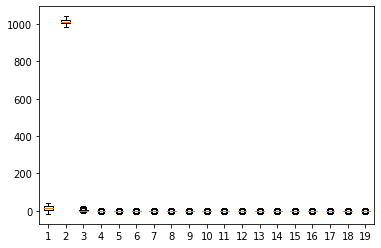

In [8]:
# Extract input features and convert them to a numpy array

#Selección de características
X = df[['TEMP', 'PRES', 'WSPM' ]].to_numpy()
 #df[['year', 'month', 'day', 'hour', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]].to_numpy()

WD = winddir_to_categorical(df[['wd']])
X = np.concatenate((X, WD), axis=1)


print(f"Input values X with shape {X.shape}. With values")


print(f" min = {X.min(axis=0)}")
print(f" mean = {X.mean(axis=0)}")
print(f" stdd = {X.std(axis=0)}")
print(f" max = {X.max(axis=0)}")

plt.boxplot(X)
plt.show()

[1.37756108e+01 1.01180038e+03 1.72047148e+00 7.51532296e-02
 1.12619833e-01 5.05421971e-02 5.86830112e-02 1.43988685e-01
 6.99984284e-02 4.45073079e-02 5.37482320e-02 3.81581015e-02
 3.91010530e-02 2.96715386e-02 6.03488920e-02 9.57724344e-02
 3.36005029e-02 3.14002829e-02 6.27062706e-02]
 min = [-2.68941826 -2.50518608 -1.42870029 -0.28506174 -0.35624812 -0.23072212
 -0.24968258 -0.41013273 -0.27434832 -0.21582511 -0.23833001 -0.19917808
 -0.20172298 -0.17486812 -0.2534261  -0.32544784 -0.1864638  -0.18005062
 -0.25865307]
 mean = [-1.02426039e-14 -1.09446446e-12  1.58522417e-14  1.72582712e-14
 -4.05981498e-15  1.36230193e-14  1.06470074e-14 -1.71220957e-14
 -1.80721207e-14  1.59185533e-15 -1.52863037e-14 -9.66857167e-16
 -1.04650289e-14 -9.16496697e-17  7.44947610e-15 -1.07559691e-14
 -7.01441105e-15 -7.47533943e-15 -1.16311731e-14]
 stdd = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 max = [2.35066639 2.92102439 7.87191495 3.50801198 2.80703236 4.33421824
 4.0050851

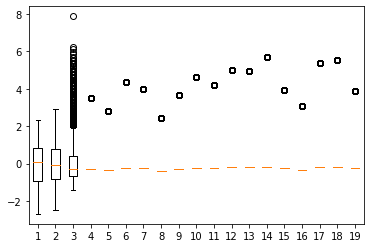

In [9]:
# Normalize (zero-center) and standardize (scale) input data
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X = scalerX.fit_transform(X)
print(scalerX.mean_)

print(f" min = {X.min(axis=0)}")
print(f" mean = {X.mean(axis=0)}")
print(f" stdd = {X.std(axis=0)}")
print(f" max = {X.max(axis=0)}")

plt.boxplot(X)
plt.show()

Target values Y with shape (31815, 2). With values
 min = [  0.2142 100.    ]
 mean = [  56.2409378 1256.5747289]
 stdd = [  57.83340531 1223.28198259]
 max = [  423. 10000.]


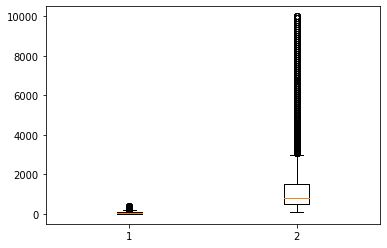

In [10]:
# Extract output features and convert them to a numpy array
Y = df[['O3', 'CO']].to_numpy()

print(f"Target values Y with shape {Y.shape}. With values")
print(f" min = {Y.min(axis=0)}")
print(f" mean = {Y.mean(axis=0)}")
print(f" stdd = {Y.std(axis=0)}")
print(f" max = {Y.max(axis=0)}")

plt.boxplot(Y)
plt.show()

[  56.2409378 1256.5747289]
 min = [-0.96876083 -0.94546862]
 mean = [-1.57228378e-16 -3.21603501e-17]
 stdd = [1. 1.]
 max = [6.34164736 7.14751414]


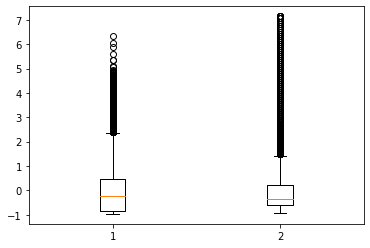

In [11]:
# Normalize (zero-center) and standardize (scale) output data
scalerY = StandardScaler()
Y = scalerY.fit_transform(Y)
print(scalerY.mean_)

print(f" min = {Y.min(axis=0)}")
print(f" mean = {Y.mean(axis=0)}")
print(f" stdd = {Y.std(axis=0)}")
print(f" max = {Y.max(axis=0)}")

plt.boxplot(Y)
plt.show()

In [12]:
# Split data into train+val and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(30224, 19)
(30224, 2)
(1591, 19)
(1591, 2)


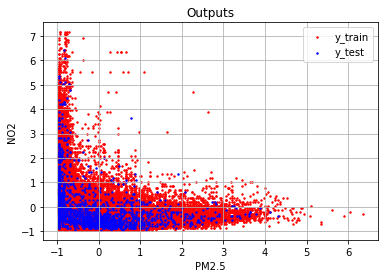

In [13]:
# Plot y_test
# Esta gráfica es para ver sólo si los sets de entrenamiento y test cubren las mismas
# áreas (¿tienen la misma distribución?). No se espera que los puntos coincidan ya que
# son dos sets distintos.
plt.scatter(y_train[:, 0], y_train[:, 1], c='r', s=2, label='y_train')
plt.scatter(y_test[:, 0], y_test[:, 1], c='b', s=2, label='y_test')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Outputs')
plt.show()

# Part 3: Create DNN model and train it

In [14]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [ ]:
# 2 capas ocultas
# Valores entre 32 y 2048
neuro = [2048,1024,512,256,128,64,32]
lote = [32, 64]
res3 = []
from random import seed
seed(1)
for f in range(len(neuro)):
  for lo in lote:
    if random() > 0.3:
      DNN = Sequential()
      DNN.add(Input(shape = X.shape[1:], name='INPUT'))

      DNN.add(Dense(units = neuro[f], activation='relu'))
      DNN.add(Dense(units = neuro[f], activation='relu'))
      
      DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

      #DNN.summary()
      DNN.compile(optimizer='adam', loss='mse')
      # Train model
      history = DNN.fit(x=x_train, y=y_train, batch_size= lo, epochs=30, verbose= 0, validation_split=0.1, shuffle=True)
      entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
      prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
      res3.append([neuro[f], neuro[f],lo, entrenamiento, prueba])

In [ ]:
df2 = pd.DataFrame(res3, columns = ['Neu 1', 'Neu 2', 'Lote', 'Entrenamiento', 'Prueba']) 
df2 = df2.sort_values(by=['Prueba'])
print(df2.head())

In [ ]:
# 3 capas ocultas
# Valores entre 32 y 2048
neuro = [2048,1024,512,256,128,64,32]
lote = [32, 64]
res3 = []
for k in range(len(neuro) - 1):
  for f in range(k + 1, len(neuro)):
    for lo in lote:
      if random() > 0.5:
        DNN = Sequential()
        DNN.add(Input(shape = X.shape[1:], name='INPUT'))

        DNN.add(Dense(units = neuro[f], activation='relu'))
        DNN.add(Dense(units = neuro[k], activation='relu'))
        DNN.add(Dense(units = neuro[f], activation='relu'))

        DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

        #DNN.summary()
        DNN.compile(optimizer='adam', loss='mse')
        # Train model
        history = DNN.fit(x=x_train, y=y_train, batch_size= lo, epochs=30, verbose= False, validation_split=0.1, shuffle=True)
        entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
        prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
        res3.append([neuro[f], neuro[k], neuro[f],lo, entrenamiento, prueba])

In [ ]:
df2 = pd.DataFrame(res3, columns = ['Neu 1', 'Neu 2', 'Neu 3', 'Lote', 'Entrenamiento', 'Prueba']) 
df2 = df2.sort_values(by=['Prueba'])
print(df2.head())

In [ ]:
# 4 capas ocultas
# Valores entre 32 y 2048
neuro = [2048,1024,512,256,128,64,32]
lote = [32, 64]
res3 = []
for k in range(len(neuro) - 1):
  for f in range(k + 1, len(neuro)):
    for lo in lote:
      if random() > 0.5:
        DNN = Sequential()
        DNN.add(Input(shape = X.shape[1:], name='INPUT'))

        DNN.add(Dense(units = neuro[f], activation='relu'))
        DNN.add(Dense(units = neuro[k], activation='relu'))
        DNN.add(Dense(units = neuro[k], activation='relu'))
        DNN.add(Dense(units = neuro[f], activation='relu'))

        DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

        #DNN.summary()
        DNN.compile(optimizer='adam', loss='mse')
        # Train model
        history = DNN.fit(x=x_train, y=y_train, batch_size= lo, epochs=30, verbose= False, validation_split=0.1, shuffle=True)
        entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
        prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
        res3.append([neuro[f], neuro[k], neuro[k],neuro[f],lo, entrenamiento, prueba])

In [ ]:
df2 = pd.DataFrame(res3, columns = ['Neu 1', 'Neu 2', 'Neu 3', 'Neu 4', 'Lote', 'Entrenamiento', 'Prueba']) 
df2 = df2.sort_values(by=['Prueba'])
print(df2.head())

In [ ]:
# 5 capas ocultas
# Valores entre 32 y 2048
neuro = [2048,1024,512,256,128,64,32]
lote = [32, 64]
res3 = []
for ñ in range(len(neuro) - 2):
  for k in range(ñ + 1, len(neuro) - 1):
    for f in range(k + 1, len(neuro)):
      for lo in lote:
        if random() > 0.7:
          DNN = Sequential()
          DNN.add(Input(shape = X.shape[1:], name='INPUT'))

          DNN.add(Dense(units = neuro[f], activation='relu'))
          DNN.add(Dense(units = neuro[k], activation='relu'))
          DNN.add(Dense(units = neuro[ñ], activation='relu'))
          DNN.add(Dense(units = neuro[k], activation='relu'))
          DNN.add(Dense(units = neuro[f], activation='relu'))

          DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

          #DNN.summary()
          DNN.compile(optimizer='adam', loss='mse')
          # Train model
          history = DNN.fit(x=x_train, y=y_train, batch_size= lo, epochs=30, verbose= False, validation_split=0.1, shuffle=True)
          entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
          prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
          res3.append([neuro[f], neuro[k], neuro[ñ], neuro[k],neuro[f],lo, entrenamiento, prueba])

In [ ]:
df2 = pd.DataFrame(res3, columns = ['Neu 1', 'Neu 2', 'Neu 3', 'Neu 4', 'Neu 5', 'Lote', 'Entrenamiento', 'Prueba']) 
df2 = df2.sort_values(by=['Prueba'])
print(df2.head())

In [ ]:
# 6 capas ocultas
# Valores entre 32 y 2048
neuro = [2048,1024,512,256,128,64,32]
lote = [32, 64]
res3 = []
for ñ in range(len(neuro) - 2):
  for k in range(ñ + 1, len(neuro) - 1):
    for f in range(k + 1, len(neuro)):
      for lo in lote:
        if random() > 0.7:
          DNN = Sequential()
          DNN.add(Input(shape = X.shape[1:], name='INPUT'))

          DNN.add(Dense(units = neuro[f], activation='relu'))
          DNN.add(Dense(units = neuro[k], activation='relu'))
          DNN.add(Dense(units = neuro[ñ], activation='relu'))
          DNN.add(Dense(units = neuro[ñ], activation='relu'))
          DNN.add(Dense(units = neuro[k], activation='relu'))
          DNN.add(Dense(units = neuro[f], activation='relu'))

          DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

          #DNN.summary()
          DNN.compile(optimizer='adam', loss='mse')
          # Train model
          history = DNN.fit(x=x_train, y=y_train, batch_size= lo, epochs=30, verbose= False, validation_split=0.1, shuffle=True)
          entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
          prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
          res3.append([neuro[f], neuro[k], neuro[ñ], neuro[ñ], neuro[k],neuro[f],lo, entrenamiento, prueba])

In [ ]:
df2 = pd.DataFrame(res3, columns = ['Neu 1', 'Neu 2', 'Neu 3', 'Neu 4', 'Neu 5', 'Neu 6', 'Lote', 'Entrenamiento', 'Prueba']) 
df2 = df2.sort_values(by=['Prueba'])
print(df2.head())

# Mejor modelo


In [ ]:
#Adagrad
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
DNN.compile(optimizer='adagrad', loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 100, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)

Epoch 1/100
1701/1701 [==============================] - 4s 2ms/step - loss: 0.8337 - val_loss: 0.6431
Epoch 2/100
1701/1701 [==============================] - 3s 2ms/step - loss: 0.5909 - val_loss: 0.5979
Epoch 3/100
1701/1701 [==============================] - 4s 2ms/step - loss: 0.5394 - val_loss: 0.5805
Epoch 4/100
1701/1701 [==============================] - 4s 2ms/step - loss: 0.5386 - val_loss: 0.5695
Epoch 5/100
1701/1701 [==============================] - 4s 2ms/step - loss: 0.5253 - val_loss: 0.5630
Epoch 6/100
1701/1701 [==============================] - 3s 2ms/step - loss: 0.5284 - val_loss: 0.5579
Epoch 7/100
1701/1701 [==============================] - 3s 2ms/step - loss: 0.5184 - val_loss: 0.5545
Epoch 8/100
1701/1701 [==============================] - 3s 2ms/step - loss: 0.5255 - val_loss: 0.5515
Epoch 9/100
1701/1701 [==============================] - 4s 2ms/step - loss: 0.5169 - val_loss: 0.5496
Epoch 10/100
1701/1701 [==============================] - 4s 2ms/step - l

In [26]:
# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

KeyError: ignored

<Figure size 864x360 with 0 Axes>

In [18]:
# Generalization metric (opcional)
min_loss = np.min([DNN.history.history['loss'][-1], DNN.history.history['val_loss'][-1]])
max_loss = np.max([DNN.history.history['loss'][-1], DNN.history.history['val_loss'][-1]])
general_loss = (max_loss - min_loss) / max_loss
print(f"Generalization loss: {general_loss:6.4f}%")

KeyError: ignored

In [23]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss:", loss_test)

Test loss: 0.45083075761795044


In [24]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

(1591, 2)


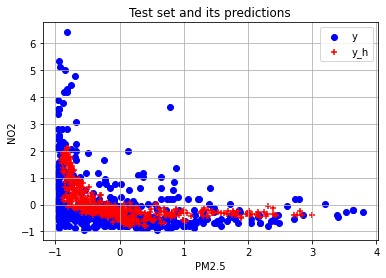

In [25]:
# Plot y_test_hat
indx = np.random.permutation(len(y_test))[:500]
plt.scatter(y_test[indx, 0], y_test[indx, 1], c='b', label='y')
plt.scatter(y_test_hat[indx, 0], y_test_hat[indx, 1], c='r', marker='+', label='y_h')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Test set and its predictions')
plt.show()

# Pruebas optimizadores

In [22]:
#SGD
from tensorflow.keras.optimizers import SGD
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
sgd = SGD(learning_rate=0.02, momentum=0.6)
DNN.compile(optimizer=sgd, loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 40, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)

Epoch 1/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.6250 - val_loss: 0.5397
Epoch 2/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.5136 - val_loss: 0.5430
Epoch 3/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.5066 - val_loss: 0.5268
Epoch 4/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.4928 - val_loss: 0.5558
Epoch 5/40
1701/1701 [==============================] - 3s 2ms/step - loss: 0.4958 - val_loss: 0.5575
Epoch 6/40
1701/1701 [==============================] - 3s 2ms/step - loss: 0.4981 - val_loss: 0.5370
Epoch 7/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.4841 - val_loss: 0.5356
Epoch 8/40
1701/1701 [==============================] - 3s 2ms/step - loss: 0.5037 - val_loss: 0.5361
Epoch 9/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.4844 - val_loss: 0.5394
Epoch 10/40
1701/1701 [==============================] - 4s 2ms/step - loss: 0.484

KeyboardInterrupt: ignored

In [ ]:
#Adagrad
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
DNN.compile(optimizer='adagrad', loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 40, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)

In [ ]:
#Adadelta
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
DNN.compile(optimizer='adadelta', loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 40, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)

In [ ]:
# RMSprop
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
DNN.compile(optimizer='rmsprop', loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 40, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)

In [ ]:
# Nadam
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
DNN.compile(optimizer='nadam', loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 40, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)

In [ ]:
# Ftrl
DNN = Sequential()
DNN.add(Input(shape = X.shape[1:], name='INPUT'))

DNN.add(Dense(units = 32, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 256, activation='relu'))
DNN.add(Dense(units = 64, activation='relu'))
DNN.add(Dense(units = 32, activation='relu'))

DNN.add(Dense(units = Y.shape[1], activation='linear', name='OUTPUT'))

#DNN.summary()
DNN.compile(optimizer='ftrl', loss='mse')
# Train model
history = DNN.fit(x=x_train, y=y_train, batch_size= 16, epochs = 40, verbose= 1, validation_split=0.1, shuffle=True)
entrenamiento = DNN.evaluate(x = x_train, y = y_train, verbose=0)
prueba = DNN.evaluate(x = x_test, y = y_test, verbose=0)
print(entrenamiento)
print(prueba)